In [138]:
import scipy.linalg as la
import numpy as np
import sympy as sp
import re
import matplotlib.pyplot as plt
from math import e, sin, cos, log, pi, tan, asin, acos, atan, atan2
from functools import partial
get_ipython().run_line_magic('matplotlib', 'notebook')


In [139]:
def get_crit(func: sp.Matrix, X: list):
    """
    func: sympy.Matrix(['x + y']),
    X: [sympy.Symbol('x'), sympy.Symbol('y')]
    return critical points
    """
    gradf = sp.simplify(func.jacobian(X))
    return sp.solve(gradf, X, dict=True)


In [140]:
def filter_point(point: list, x_min, x_max, y_min, y_max):
    """
    point: [(1, 2), (2, 3)] – list of tuples, critical points for filtering
    x_min, x_max, y_min, y_max – int or float, constraints for variables
    """
    x, y = point.values()
    if x_min <= x <= x_max and y_min <= y <= y_max:
        return True
    return False


In [141]:
def type_point(func, X, x0):
    """
    func: sympy.Matrix(['x + y']),
    X: [sympy.Symbol('x'), sympy.Symbol('y')],
    x0: (1, 2) – tuple of int or float numbers, critical point
    return type of critical points
    """
    hessianf = sp.simplify(sp.hessian(func, X))
    H = np.array(hessianf.subs(dict(zip(X, x0)))).astype('float')
    l, v = la.eig(H)
    if(np.all(np.greater(l, np.zeros(2)))):
        return 'minimum'
    elif(np.all(np.less(l, np.zeros(2)))):
        return 'maximum'
    else:
        return 'saddle'


In [142]:
def right_func(func, X):
    template = re.compile(r'[a-zA-Zа-яА-Я]{2,}')
    for symbol in func:
        if symbol.isalpha() and sp.Symbol(symbol) not in X:
            return False  # неизвестная переменная в функции
        elif template.findall(func):
            return False
    return True
    # еще надо обработать пропущенный знак типа 2x1 + 15x2


In [152]:
def get_data():
    data = dict()
    var_names = 'Введите названия переменных (x y): '
    input_x = 'Введите ограничения для x (-10 10): '
    input_y = 'Введите ограничения для y (-10 10): '
    raise_x = 'Границы для ограничения x перепутаны'
    raise_y = 'Границы для ограничения y перепутаны'
    template = re.compile(r'[a-zA-Zа-яА-Я]{2,}')
    data['X'] = sp.symbols(input(var_names).split())
    assert len(data['X']) == 2, 'переменные заданы неверно'
    assert len(str(data['X'][0])) == 1, 'переменные заданы неверно'
    assert len(str(data['X'][1])) == 1, 'перменные заданы неверно'
    f = input('Введите функцию (y*x+2): ')
    trigonom_lst = 'e, sin, cos, log, pi, tan, asin, acos, atan, atan2'.split(', ')
    if template.findall(f):
        check_lst = template.findall(f)
        for i in check_lst:
            if i not in trigonom_lst:
                assert i in trigonom_lst, 'переменные заданы неверно'
        #assert right_func(f, data['X']), 'функция задана неверно'
    data['func'] = sp.Matrix([f])
    data['limit'] = int(input('Есть ли ограничения? (1 – да, 0 – нет): '))
    if data['limit']:
        str_x = input_x
        str_y = input_y
        try:
            data['x_min'], data['x_max'] = map(lambda x: float(x), input(str_x).split())
            data['y_min'], data['y_max'] = map(lambda y: float(y), input(str_y).split())
        except ValueError:
            raise ValueError('Ограничения заданы неверно')
        assert data['x_min'] < data['x_max'], raise_x
        assert data['y_min'] < data['y_max'], raise_y
    return data


In [176]:
def get_extremums():
    """
    returns a tuple from the source data and the results of the function.
    data: dict - dictionary of source data, stores the name of variables,
    function, constraints.
    points: list – a list of tuples, each element stores a point,
    the value of the function at the point and the type of extremum.
    """
    data = get_data()
    crit = get_crit(data['func'], data['X'])
    if data['limit']:
        f = partial(filter_point,
                    x_min=data['x_min'], x_max=data['x_max'],
                    y_min=data['y_min'], y_max=data['y_max'])
        crit = list(filter(f, crit))
    if len(crit) > 40:
        n = int(input('Точек больше 40, сколько вывести? '))
        crit = crit[:n]
    points = []
    print(crit)
    for x in crit:
        try:
            x1, x2 = x.values()
        except:
            continue
        z = data['func'].subs(x)[0]
        type_x = type_point(data['func'], data['X'], x.values())
        points.append(((x1, x2), z, type_x))
    return data, points


In [173]:
def show_chart(data, points):
    try:
        func = data['func']
        args = data['X']
        fig = plt.figure(figsize=(15, 15))
        ax = fig.add_subplot(111, projection='3d')
        x_min = int(min(p[0][0] for p in points)) - 5
        x_max = int(max(p[0][0] for p in points)) + 5
        y_min = int(min(p[0][1] for p in points)) - 5
        y_max = int(max(p[0][1] for p in points)) + 5
        x_linsp = np.linspace(x_min, x_max, 100)
        y_linsp = np.linspace(y_min, y_max, 100)
        x_linsp, y_linsp = np.meshgrid(x_linsp, y_linsp)
        z_linsp = sp.lambdify(args, func)(x_linsp, y_linsp)[0][0]
        x = [float(p[0][0]) for p in points]
        y = [float(p[0][1]) for p in points]
        z = [float(p[1]) for p in points]
        ax.plot_surface(x_linsp, y_linsp, z_linsp, cmap=plt.cm.coolwarm, alpha=0.5)
        plt.title(f'z{args[0], args[1]} = {func[0]}', fontsize=11)
        ax.set_xlabel(args[0], color='blue', fontsize=20)  
        ax.set_ylabel(args[1], color='blue', fontsize=20) 
        ax.set_zlabel('z', color='blue', fontsize=20)
        ax.scatter(x, y, z, c='red', s=50, alpha=1, label='extremums')
        plt.legend(fontsize='small')
        plt.show()
    except:
        print('\nНе удается построить график из-за некорректной записи искходного уравнения.')


In [174]:
def main():
    while True:
        try:
            data, points = get_extremums()
            break
        except AssertionError as msg:
            print('\nДанные введены некорректно, попробуйте заново:')
        except TypeError as msg:
            print('\nВозникла проблема с комплексными числами, которые не поддерживаются.')
        except ValueError as msg:
            print(msg)
            print('\nВведено неверное значение, попробуйте снова: ')
        
    print(points)
    show_chart(data, points)

Введите названия переменных (x y): x y
Введите функцию (y*x+2): sin(x*y)
Есть ли ограничения? (1 – да, 0 – нет): 0
[{x: pi/(2*y)}, {x: 3*pi/(2*y)}, {x: 0, y: 0}]
[((0, 0), 0, 'saddle')]


<IPython.core.display.Javascript object>


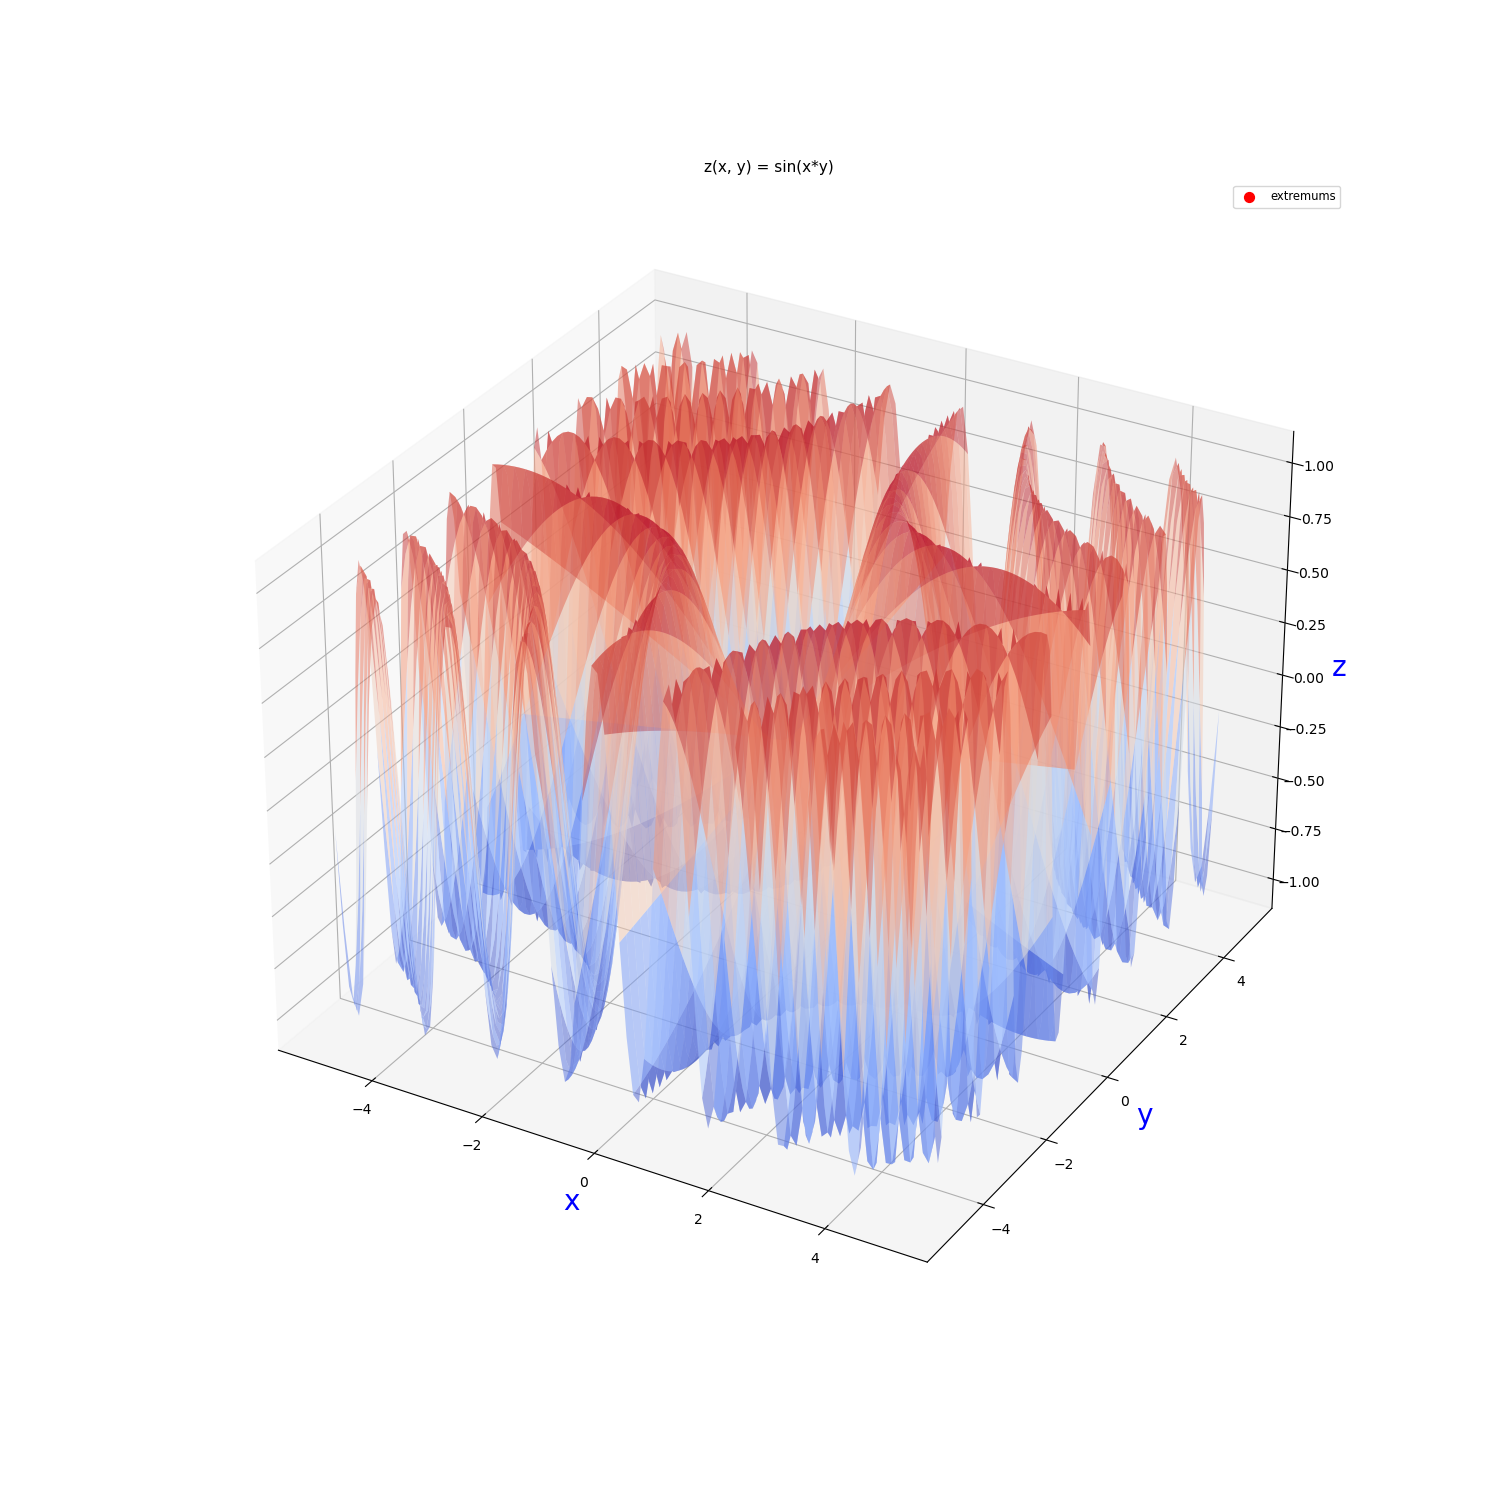

In [177]:
main()

In [168]:
template = re.compile(r'[a-zA-Zа-яА-Я]{2,}')
template.findall('sin(x+y)')

['sin']

In [151]:
'e, sin, cos, log, pi, tan, asin, acos, atan, atan2'.split(', ')

['e', 'sin', 'cos', 'log', 'pi', 'tan', 'asin', 'acos', 'atan', 'atan2']

In [167]:
trigonom_lst = 'e, sin, cos, log, pi, tan, asin, acos, atan, atan2'.split(', ')
if template.findall('sin(x+y)'):
    check_lst = template.findall('sin(x+y)')
    print(check_lst)
    for i in check_lst:
        print(i)
        if i not in trigonom_lst:
            print(i)
            assert i in trigonom_lst, 'переменные заданы неверно'

['sin']
sin
